## Problem Statement

### Context


AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalized campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customer queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help


### Objective

To identify different segments in the existing customer, based on their spending patterns as well as past interaction with the bank, using clustering algorithms, and provide recommendations to the bank on how to better market to and service these customers.


###  Data Description

The data provided is of various customers of a bank and their financial attributes like credit limit, the total number of credit cards the customer has, and different channels through which customers have contacted the bank for any queries (including visiting the bank, online and through a call center).

**Data Dictionary**

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of Visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

## Importing necessary libraries and data

In [1]:
%load_ext nb_black

# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# libaries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

# to scale the data using z-score
from sklearn.preprocessing import StandardScaler

# to compute distances
from scipy.spatial.distance import cdist, pdist

# to perform k-means clustering and compute silhouette scores
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# to visualize the elbow curve and silhouette scores
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

# to perform hierarchical clustering, compute cophenetic correlation, and create dendrograms
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet

# to suppress warnings
import warnings

warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

In [2]:
data = pd.read_excel('Credit+Card+Customer+Data.xlsx')

<IPython.core.display.Javascript object>

## Data Overview

- Observations
- Sanity checks

In [3]:
df=data.copy()

<IPython.core.display.Javascript object>

In [4]:
df.shape

(660, 7)

<IPython.core.display.Javascript object>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


<IPython.core.display.Javascript object>

In [6]:
df.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [7]:
df.nunique()

Sl_No                  660
Customer Key           655
Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

<IPython.core.display.Javascript object>

In [8]:
df.drop(columns=['Sl_No','Customer Key'],inplace=True)

<IPython.core.display.Javascript object>

In [9]:
df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,100000,2,1,1,0
1,50000,3,0,10,9
2,50000,7,1,3,4
3,30000,5,1,1,4
4,100000,6,0,12,3


<IPython.core.display.Javascript object>

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.0,18000.0,48000.0,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.0,5.0,6.0,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.0,2.0,4.0,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.0,2.0,4.0,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.0,3.0,5.0,10.0


<IPython.core.display.Javascript object>

### Data Overview Summary
* There are 660 rows and 7 columns.
* All columns are numerical.
* There are no missing values as there is a 660 count for each column
* There are duplicated values in all columns with the exception of the `Sl_No` column, but I have placed a focus on the `Customer Key` column as it indicates there may be a duplication in customer data
* I am choosing to drop `SL_No` and `Customer Key` columns as it won't provide any deeper insight into the objective.
* The average credit limit for customers is about $35k
* 50% of customers have 5 or more credit cards
* Customer interactions with banks average around 2.5-3.5 times

## Exploratory Data Analysis (EDA)

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

### Questions

1. How is the distrubution of average credit limit of customer?
2. What percenatage of the customers have never made a service-related call to the bank?
3. What percentage of customers have never logged in to the online portal?
4. How many customers have never visited bank?
3. How are the different variables correlated with each other?

In [11]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

<IPython.core.display.Javascript object>

In [12]:
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

<IPython.core.display.Javascript object>

### Univariate Analysis

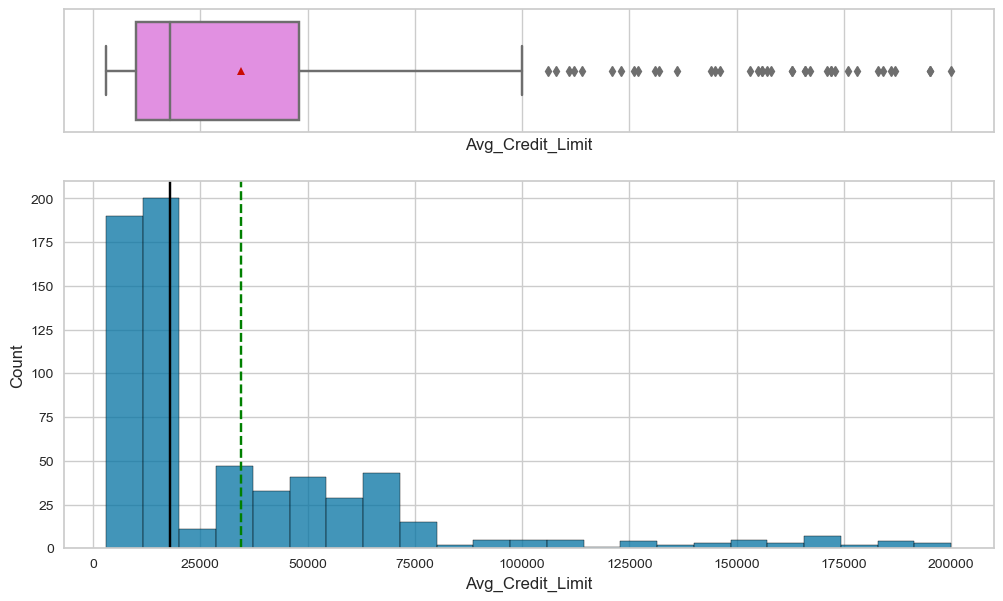

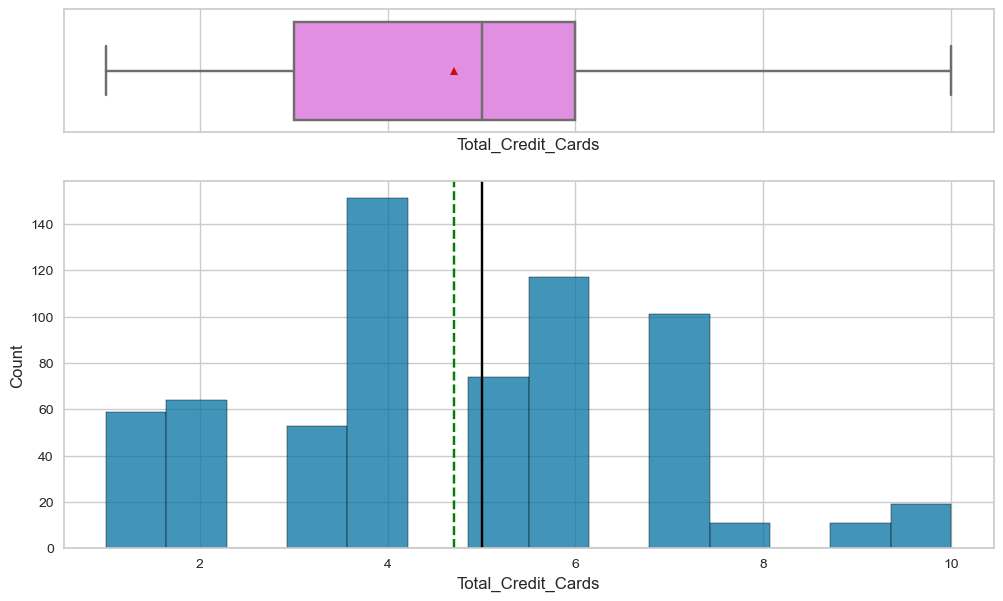

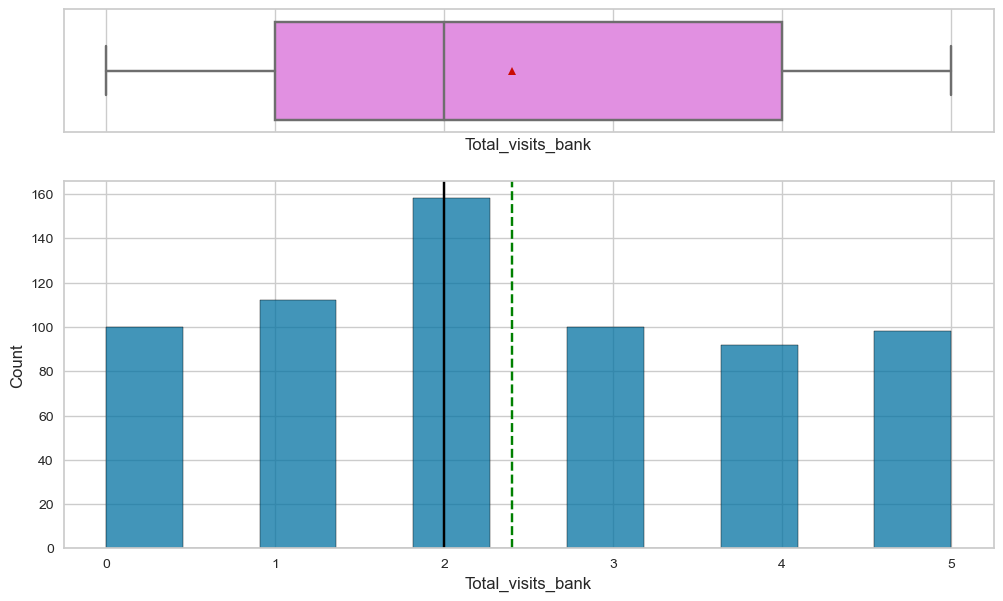

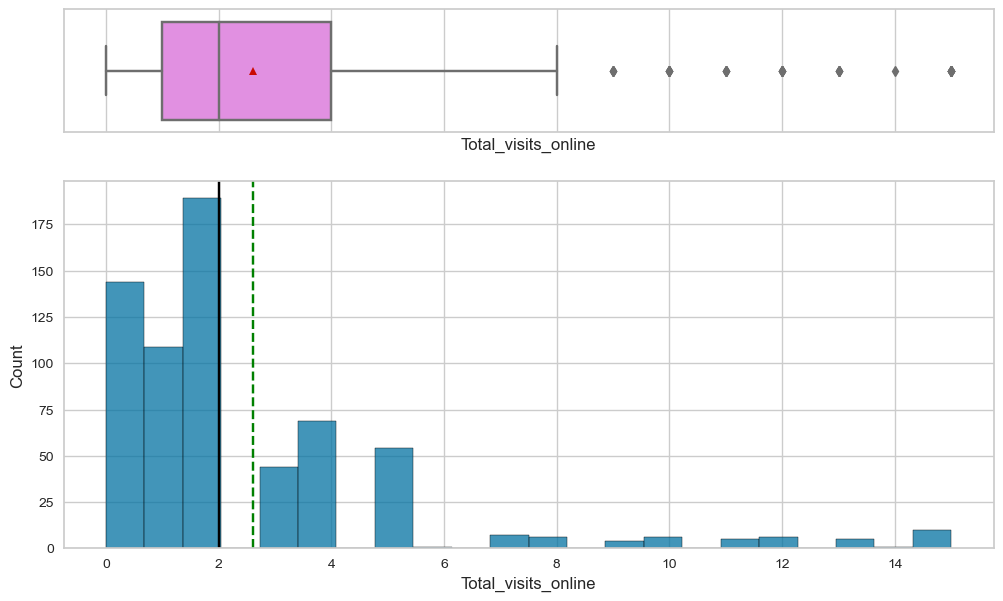

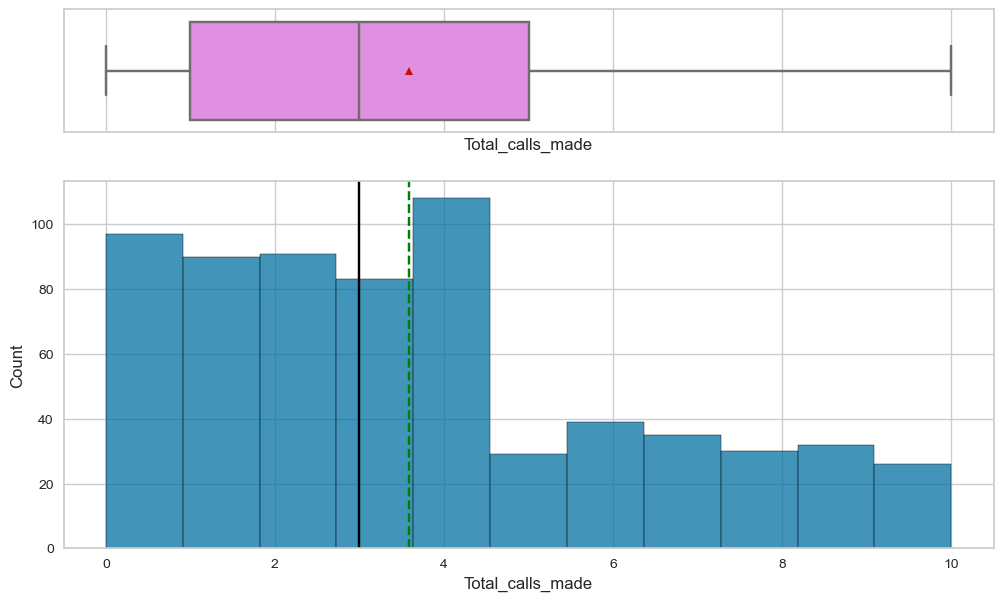

<IPython.core.display.Javascript object>

In [13]:
for col in df.columns:
    histogram_boxplot(df, col)

##### **Observations**
* Average credit limit has a right-skewed distributions with upper outliers, which indicated the presence of customers with abnormally large credit limits
* 75% of customers visit online around 4 times, however there are outliers of customers visting 8 or more times
* 75 % of customers have called 5 times
* 25% of customers have at least 3 credit cards

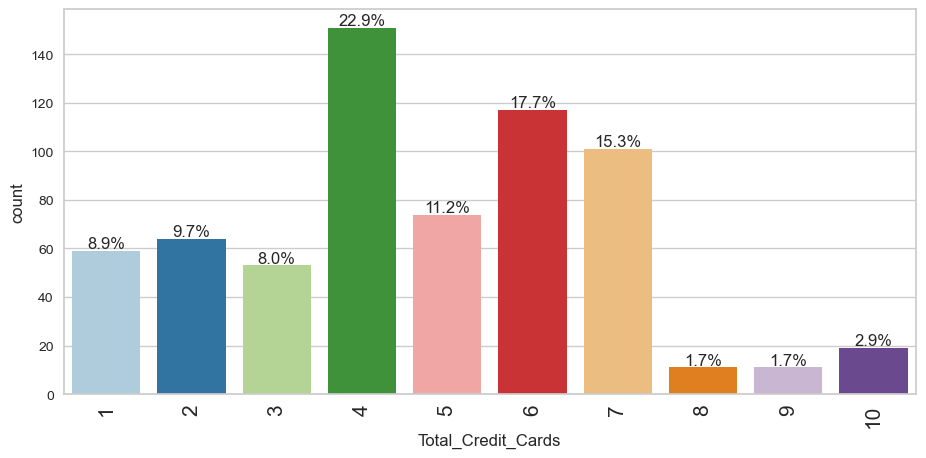

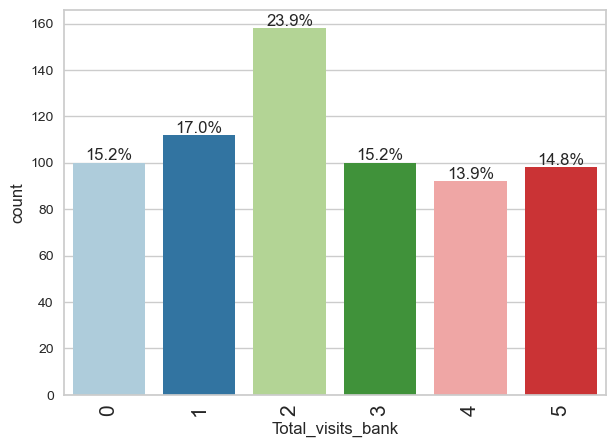

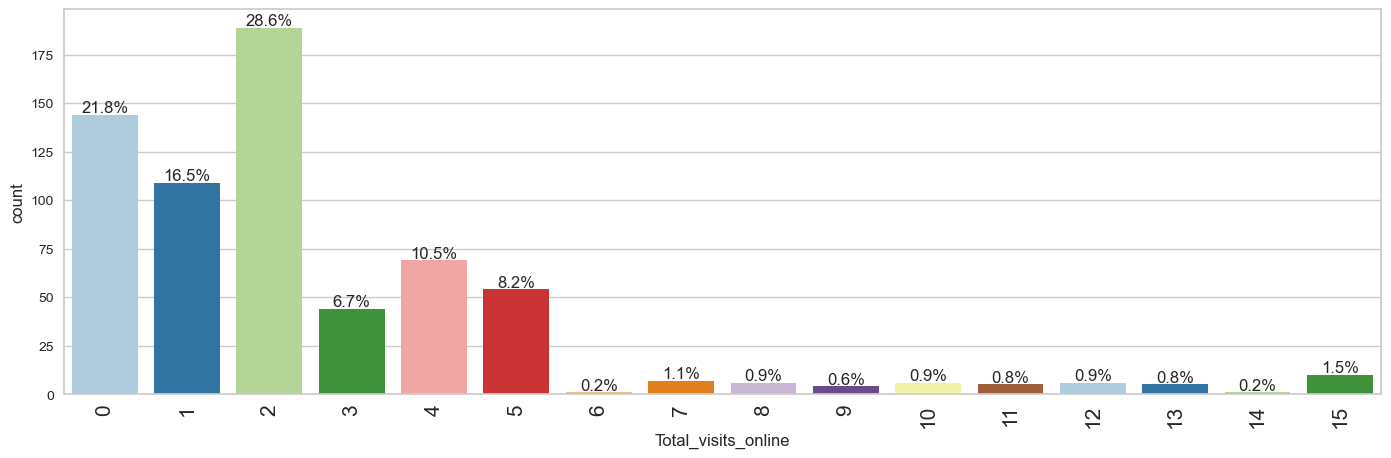

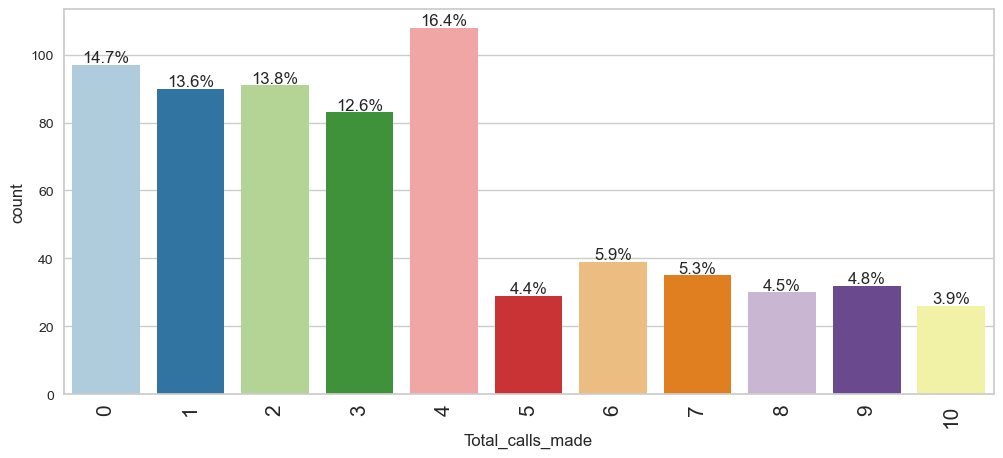

<IPython.core.display.Javascript object>

In [14]:
for col in df.columns.tolist()[1:]:
    labeled_barplot(df, col, perc=True)

##### **Observations**
* 23% of customers have a total of 4 credit cards
* 24% of customers visit the bank 2 times
* 29% of customers visit online 2 times
* Most customers will call the bank between 1-4 times

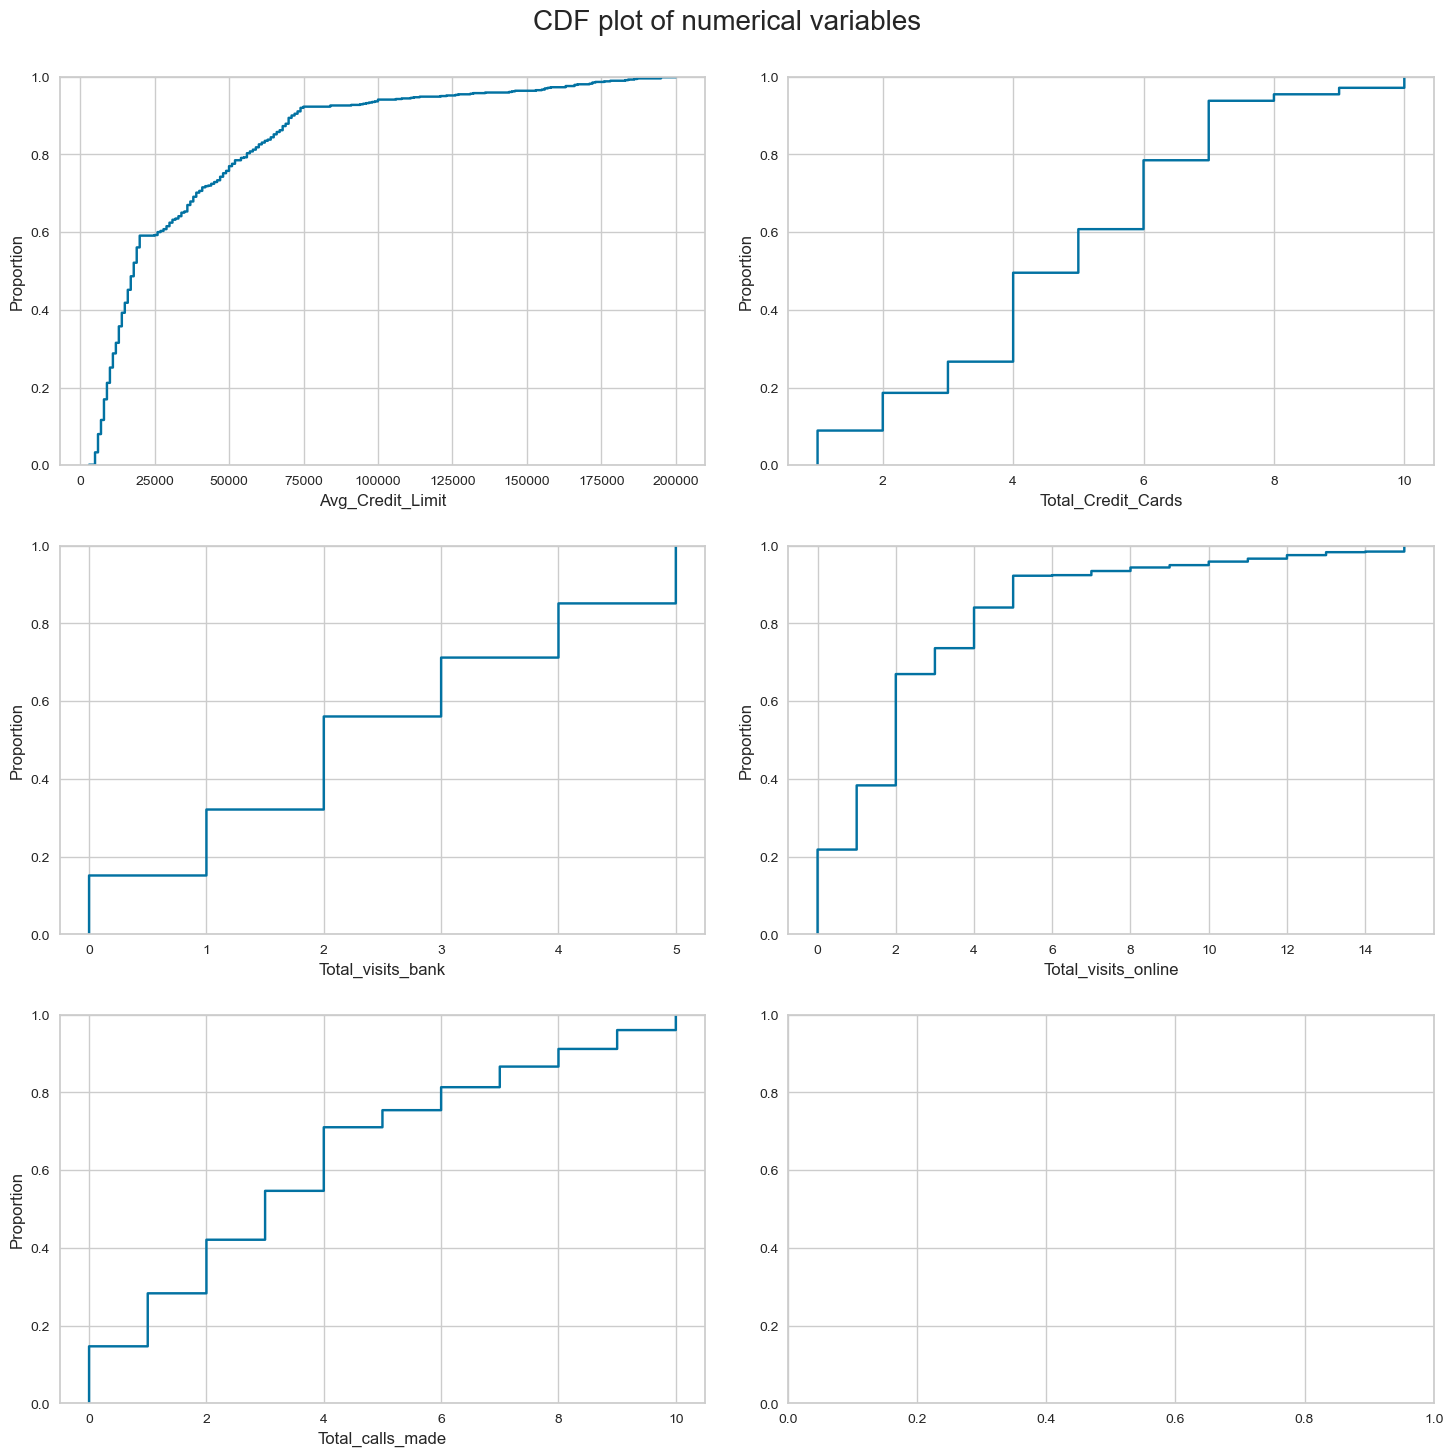

<IPython.core.display.Javascript object>

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle("CDF plot of numerical variables", fontsize=20)

counter = 0

for ii in range(3):
    sns.ecdfplot(data=df, ax=axes[ii][0], x=df.columns.tolist()[counter])
    counter = counter + 1
    if counter != 5:
        sns.ecdfplot(data=df, ax=axes[ii][1], x=df.columns.tolist()[counter])
        counter = counter + 1
    else:
        pass

fig.tight_layout(pad=2.0)

##### **Observations**
* There's genereally an even proportion of customers visiting the bank
* The majority of customers have less than $75k of credit limit

### Bivariate Analysis

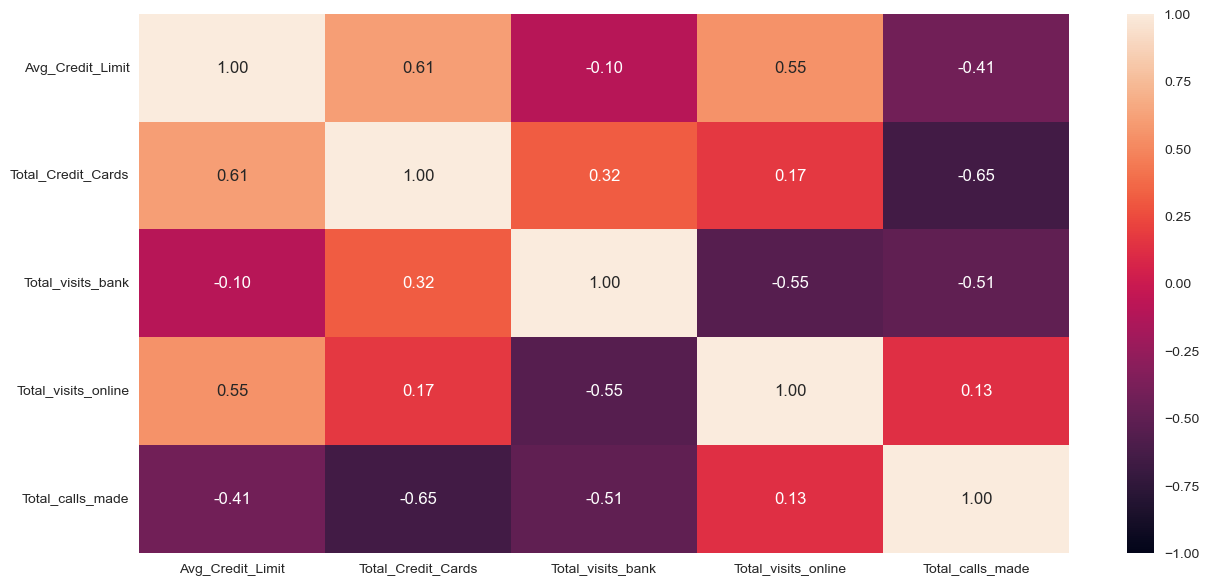

<IPython.core.display.Javascript object>

In [16]:
plt.figure(figsize=(15, 7))
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f")
plt.show()

##### **Observations**
* `Avg_Credit_Limit` and `Total_Credit_Cards` are highly correlated as well as `Avg_Credit_Limit` and `Total_visits_online`.

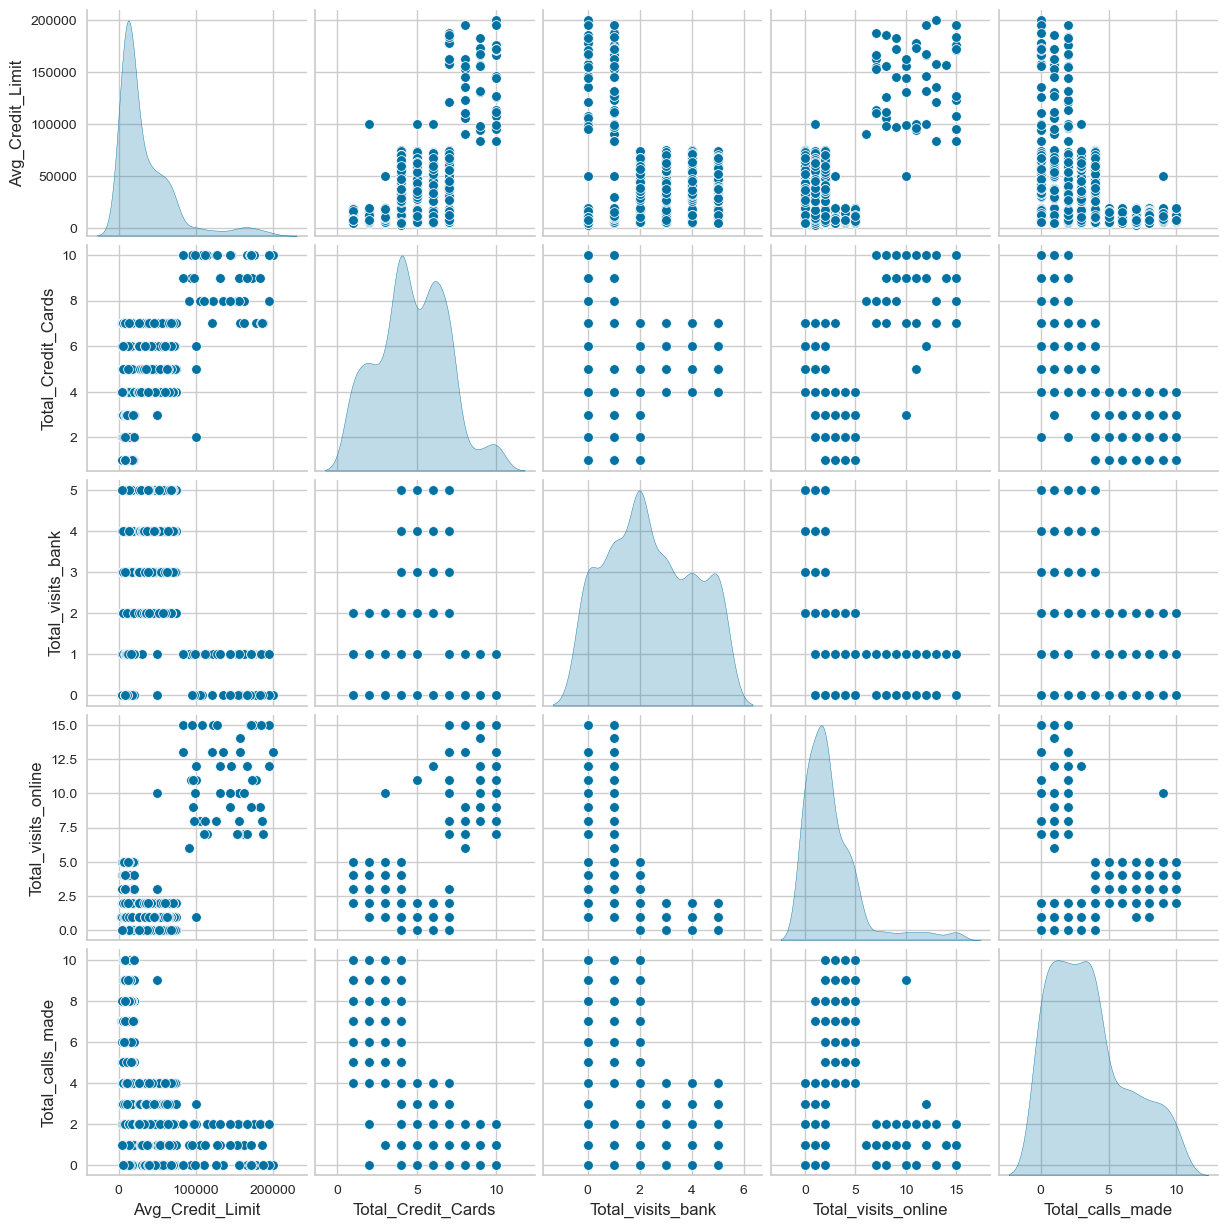

<IPython.core.display.Javascript object>

In [17]:
sns.pairplot(data=df, diag_kind="kde")
plt.show()

##### **Observations**
* Customers with higher credit limit are more frequent online users. 
* Additionally, they also have a higher total numnber of credit cards.

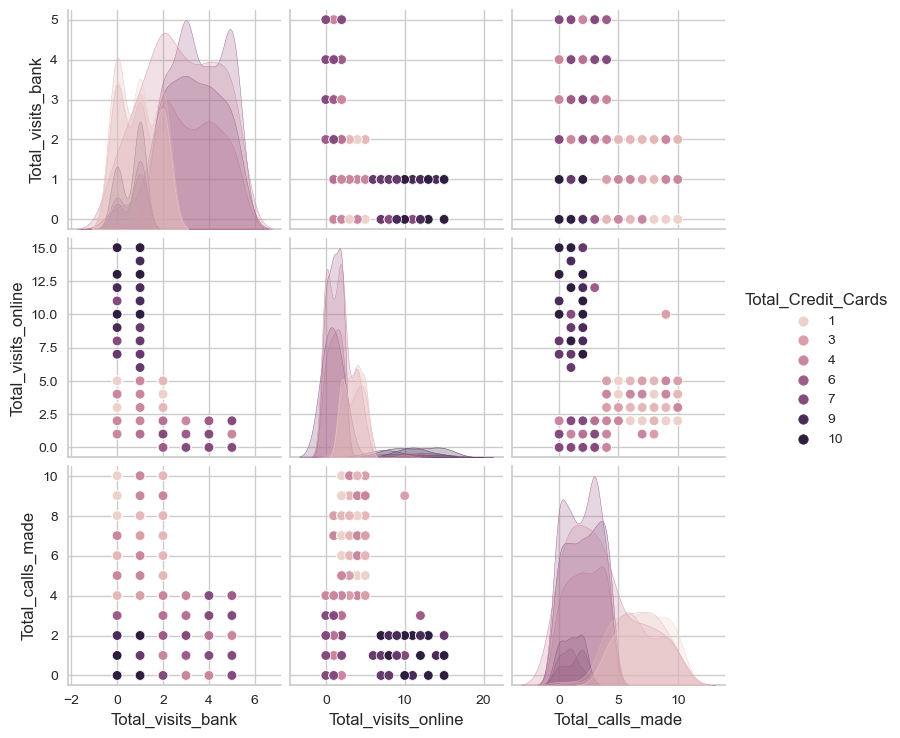

<IPython.core.display.Javascript object>

In [18]:
sns.pairplot(
    data=df[
        [
            "Total_visits_bank",
            "Total_visits_online",
            "Total_calls_made",
            "Total_Credit_Cards",
        ]
    ],
    hue="Total_Credit_Cards",
)

plt.show()

##### **Observations**
* Customers that have a higher total credit cards are frequent online visiters
* Customers that have a lower total credit cards are likelier to visit a bank or make a call

## Data Preprocessing



- Duplicate value check
- Missing value treatment
- Outlier check
- Feature engineering (if needed)
- Any other preprocessing steps (if needed)

In [19]:
#reconfirming there are no missing values
df.isna().sum()

Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

<IPython.core.display.Javascript object>

In [20]:
num_col= df.columns
num_col

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

<IPython.core.display.Javascript object>

In [21]:
#scaling the data 
sc = StandardScaler()
subset = df.copy() ## Complete the code to scale the data
subset_scaled = sc.fit_transform(subset)

<IPython.core.display.Javascript object>

In [22]:
# creating a dataframe of the scaled data
subset_scaled_df = pd.DataFrame(subset_scaled, columns=subset.columns)

<IPython.core.display.Javascript object>

In [23]:
subset_scaled_df.head()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739


<IPython.core.display.Javascript object>

## K-means Clustering

In [24]:
#create a copy of the scaled dataset to manipulate for k-means 
k_means_df=subset_scaled_df.copy()

<IPython.core.display.Javascript object>

### Elbow Method

Number of Clusters: 2 	Average Distortion: 2040.9898164784947
Number of Clusters: 3 	Average Distortion: 933.0437490000531
Number of Clusters: 4 	Average Distortion: 780.773689555177
Number of Clusters: 5 	Average Distortion: 704.4759188657513
Number of Clusters: 6 	Average Distortion: 642.4285451423211
Number of Clusters: 7 	Average Distortion: 600.2238778375963
Number of Clusters: 8 	Average Distortion: 574.4418958177622
Number of Clusters: 9 	Average Distortion: 538.8269188945013
Number of Clusters: 10 	Average Distortion: 509.16313788912544


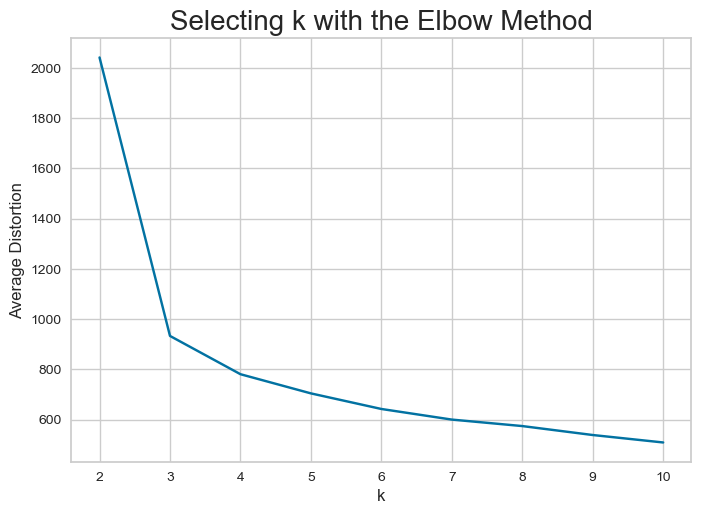

<IPython.core.display.Javascript object>

In [25]:
clusters = range(2, 11)
meanDistortions = []

for k in clusters:
    model = KMeans(n_clusters=k, random_state=1)
    model.fit(subset_scaled_df)
    prediction = model.predict(k_means_df)
    distortion = sum(
        np.min(cdist(k_means_df, model.cluster_centers_, "euclidean"), axis=1) ** 2)

    meanDistortions.append(distortion)

    print("Number of Clusters:", k, "\tAverage Distortion:", distortion)

plt.plot(clusters, meanDistortions, "bx-")
plt.xlabel("k")
plt.ylabel("Average Distortion")
plt.title("Selecting k with the Elbow Method", fontsize=20)
plt.show()

##### **Observations**
* In the plot, the elbow is seen for K=3 and K=4. 
* Based on the Average distortion scores, there is also a significant drop in K=5 and K=6 so we can also observe those by usingr the sillhouette score 

### Silhouette Score

For n_clusters = 2, the silhouette score is 0.41842496663230405
For n_clusters = 3, the silhouette score is 0.5157182558882754
For n_clusters = 4, the silhouette score is 0.355667061937737
For n_clusters = 5, the silhouette score is 0.2717470361094591
For n_clusters = 6, the silhouette score is 0.25590676529850875
For n_clusters = 7, the silhouette score is 0.2479864465613871
For n_clusters = 8, the silhouette score is 0.2414240144772954
For n_clusters = 9, the silhouette score is 0.21846450507663684


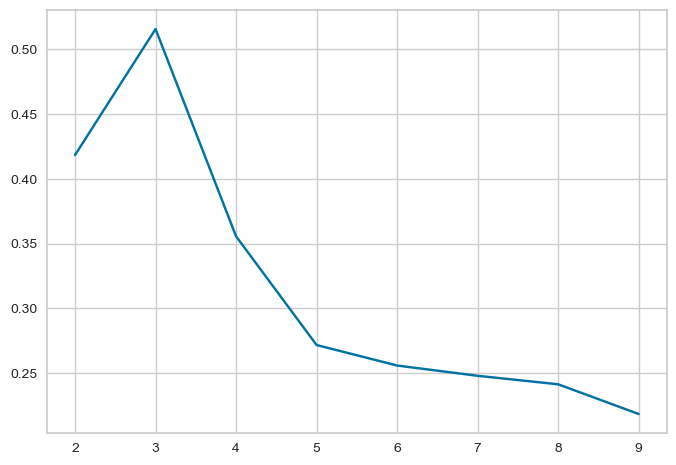

<IPython.core.display.Javascript object>

In [26]:
sil_score = []
cluster_list = range(2, 10)
for n_clusters in cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=1)
    preds = clusterer.fit_predict((subset_scaled_df))
    score = silhouette_score(k_means_df, preds)
    sil_score.append(score)
    print("For n_clusters = {}, the silhouette score is {}".format(n_clusters, score))
    
plt.plot(cluster_list, sil_score)

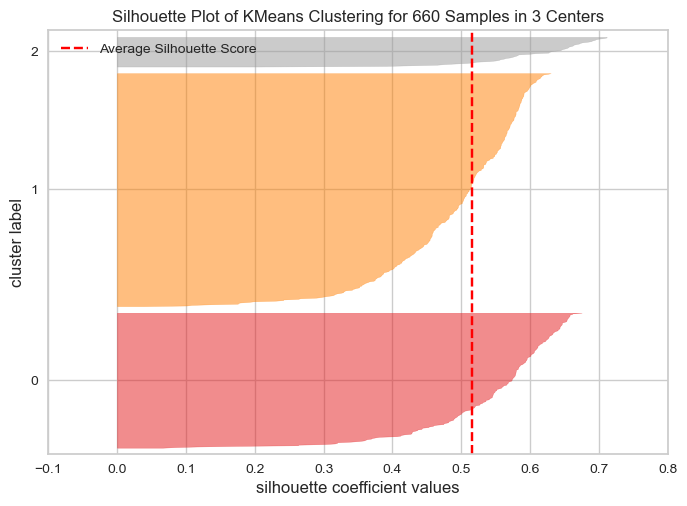

<IPython.core.display.Javascript object>

In [27]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(3, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

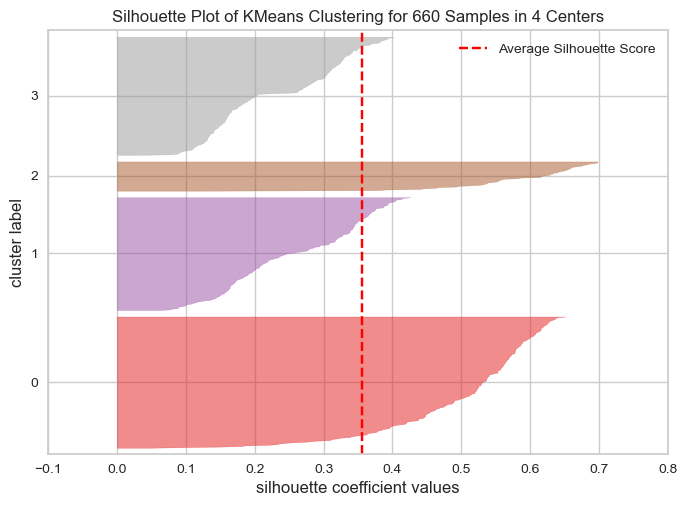

<IPython.core.display.Javascript object>

In [28]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(4, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

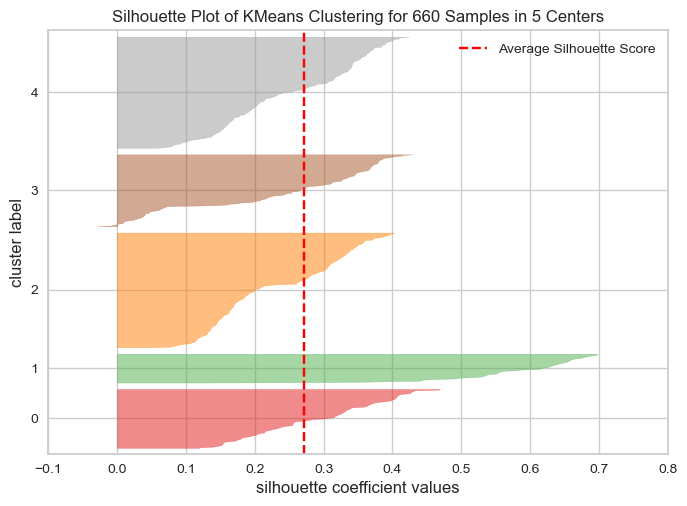

<IPython.core.display.Javascript object>

In [29]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(5, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

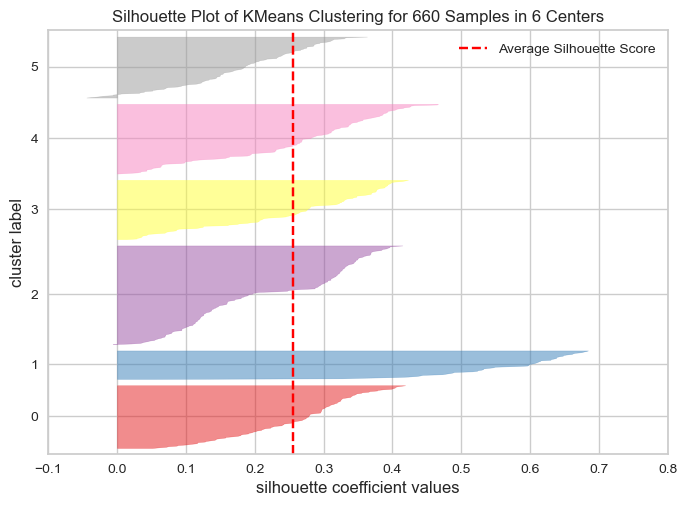

<IPython.core.display.Javascript object>

In [30]:
# finding optimal no. of clusters with silhouette coefficients
visualizer = SilhouetteVisualizer(KMeans(6, random_state=1))
visualizer.fit(k_means_df)
visualizer.show();

##### **Observations**
* Based on the sillhoutte scores, it seems that K=3 a good value as it has the highest value closes to 1 and is consistent with the results of the elbow method
* Using the silhouette visualizer, we've determined that K=5 and K=6 are not good candidates as they have negative silhouette coefficient values 
* **In comparing the elbow method and sillhouette score along with the visualizer properties, I will use K=3**

### Applying KMeans clustering for k=3

In [31]:
kmeans = KMeans(n_clusters=3, random_state=0)
kmeans.fit(k_means_df)

KMeans(n_clusters=3, random_state=0)

<IPython.core.display.Javascript object>

In [32]:
df_unscaled=df.copy() #copy of original data

#adding kmeans cluster labels to the original and scaled dataframes
k_means_df["K_means_clusters"] = kmeans.labels_
df_unscaled["K_means_clusters"] = kmeans.labels_

k_means_df.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K_means_clusters
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,1
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593,1
6,1.740187,0.135694,-1.473731,2.861408,-0.553005,2
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271,1
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005,1
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326,1


<IPython.core.display.Javascript object>

## Hierarchical Clustering

In [33]:
#copy of scaled dataset to manipulate for hierarchal clustering
hc_df=subset_scaled_df.copy()

<IPython.core.display.Javascript object>

In [34]:
# list of distance metrics
distance_metrics = ["euclidean", "chebyshev", "mahalanobis", "cityblock"]

# list of linkage methods
linkage_methods = ["single", "complete", "average", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for dm in distance_metrics:
    for lm in linkage_methods:
        Z = linkage(hc_df, metric=dm, method=lm)
        c, coph_dists = cophenet(Z, pdist(hc_df))
        print(
            "Cophenetic correlation for {} distance and {} linkage is {}.".format(
                dm.capitalize(), lm, c
            )
        )
        if high_cophenet_corr < c:
            high_cophenet_corr = c
            high_dm_lm[0] = dm
            high_dm_lm[1] = lm

Cophenetic correlation for Euclidean distance and single linkage is 0.7391220243806552.
Cophenetic correlation for Euclidean distance and complete linkage is 0.8599730607972423.
Cophenetic correlation for Euclidean distance and average linkage is 0.8977080867389372.
Cophenetic correlation for Euclidean distance and weighted linkage is 0.8861746814895477.
Cophenetic correlation for Chebyshev distance and single linkage is 0.7382354769296767.
Cophenetic correlation for Chebyshev distance and complete linkage is 0.8533474836336782.
Cophenetic correlation for Chebyshev distance and average linkage is 0.8974159511838106.
Cophenetic correlation for Chebyshev distance and weighted linkage is 0.8913624010768603.
Cophenetic correlation for Mahalanobis distance and single linkage is 0.7058064784553605.
Cophenetic correlation for Mahalanobis distance and complete linkage is 0.6663534463875362.
Cophenetic correlation for Mahalanobis distance and average linkage is 0.8326994115042136.
Cophenetic co

<IPython.core.display.Javascript object>

In [35]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print(
    "Highest cophenetic correlation is {}, which is obtained with {} distance and {} linkage.".format(
        high_cophenet_corr, high_dm_lm[0].capitalize(), high_dm_lm[1]
    )
)

Highest cophenetic correlation is 0.8977080867389372, which is obtained with Euclidean distance and average linkage.


<IPython.core.display.Javascript object>

In [36]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

high_cophenet_corr = 0
high_dm_lm = [0, 0]

for lm in linkage_methods:
    Z = linkage(hc_df, metric="euclidean", method=lm)
    c, coph_dists = cophenet(Z, pdist(hc_df))
    print("Cophenetic correlation for {} linkage is {}.".format(lm, c))
    if high_cophenet_corr < c:
        high_cophenet_corr = c
        high_dm_lm[0] = "euclidean"
        high_dm_lm[1] = lm

Cophenetic correlation for single linkage is 0.7391220243806552.
Cophenetic correlation for complete linkage is 0.8599730607972423.
Cophenetic correlation for average linkage is 0.8977080867389372.
Cophenetic correlation for centroid linkage is 0.8939385846326323.
Cophenetic correlation for ward linkage is 0.7415156284827493.
Cophenetic correlation for weighted linkage is 0.8861746814895477.


<IPython.core.display.Javascript object>

In [37]:
# printing the combination of distance metric and linkage method with the highest cophenetic correlation
print()
print(
    "Highest cophenetic correlation is {}, which is obtained with {} linkage.".format(
        high_cophenet_corr, high_dm_lm[1]
    )
)


Highest cophenetic correlation is 0.8977080867389372, which is obtained with average linkage.


<IPython.core.display.Javascript object>

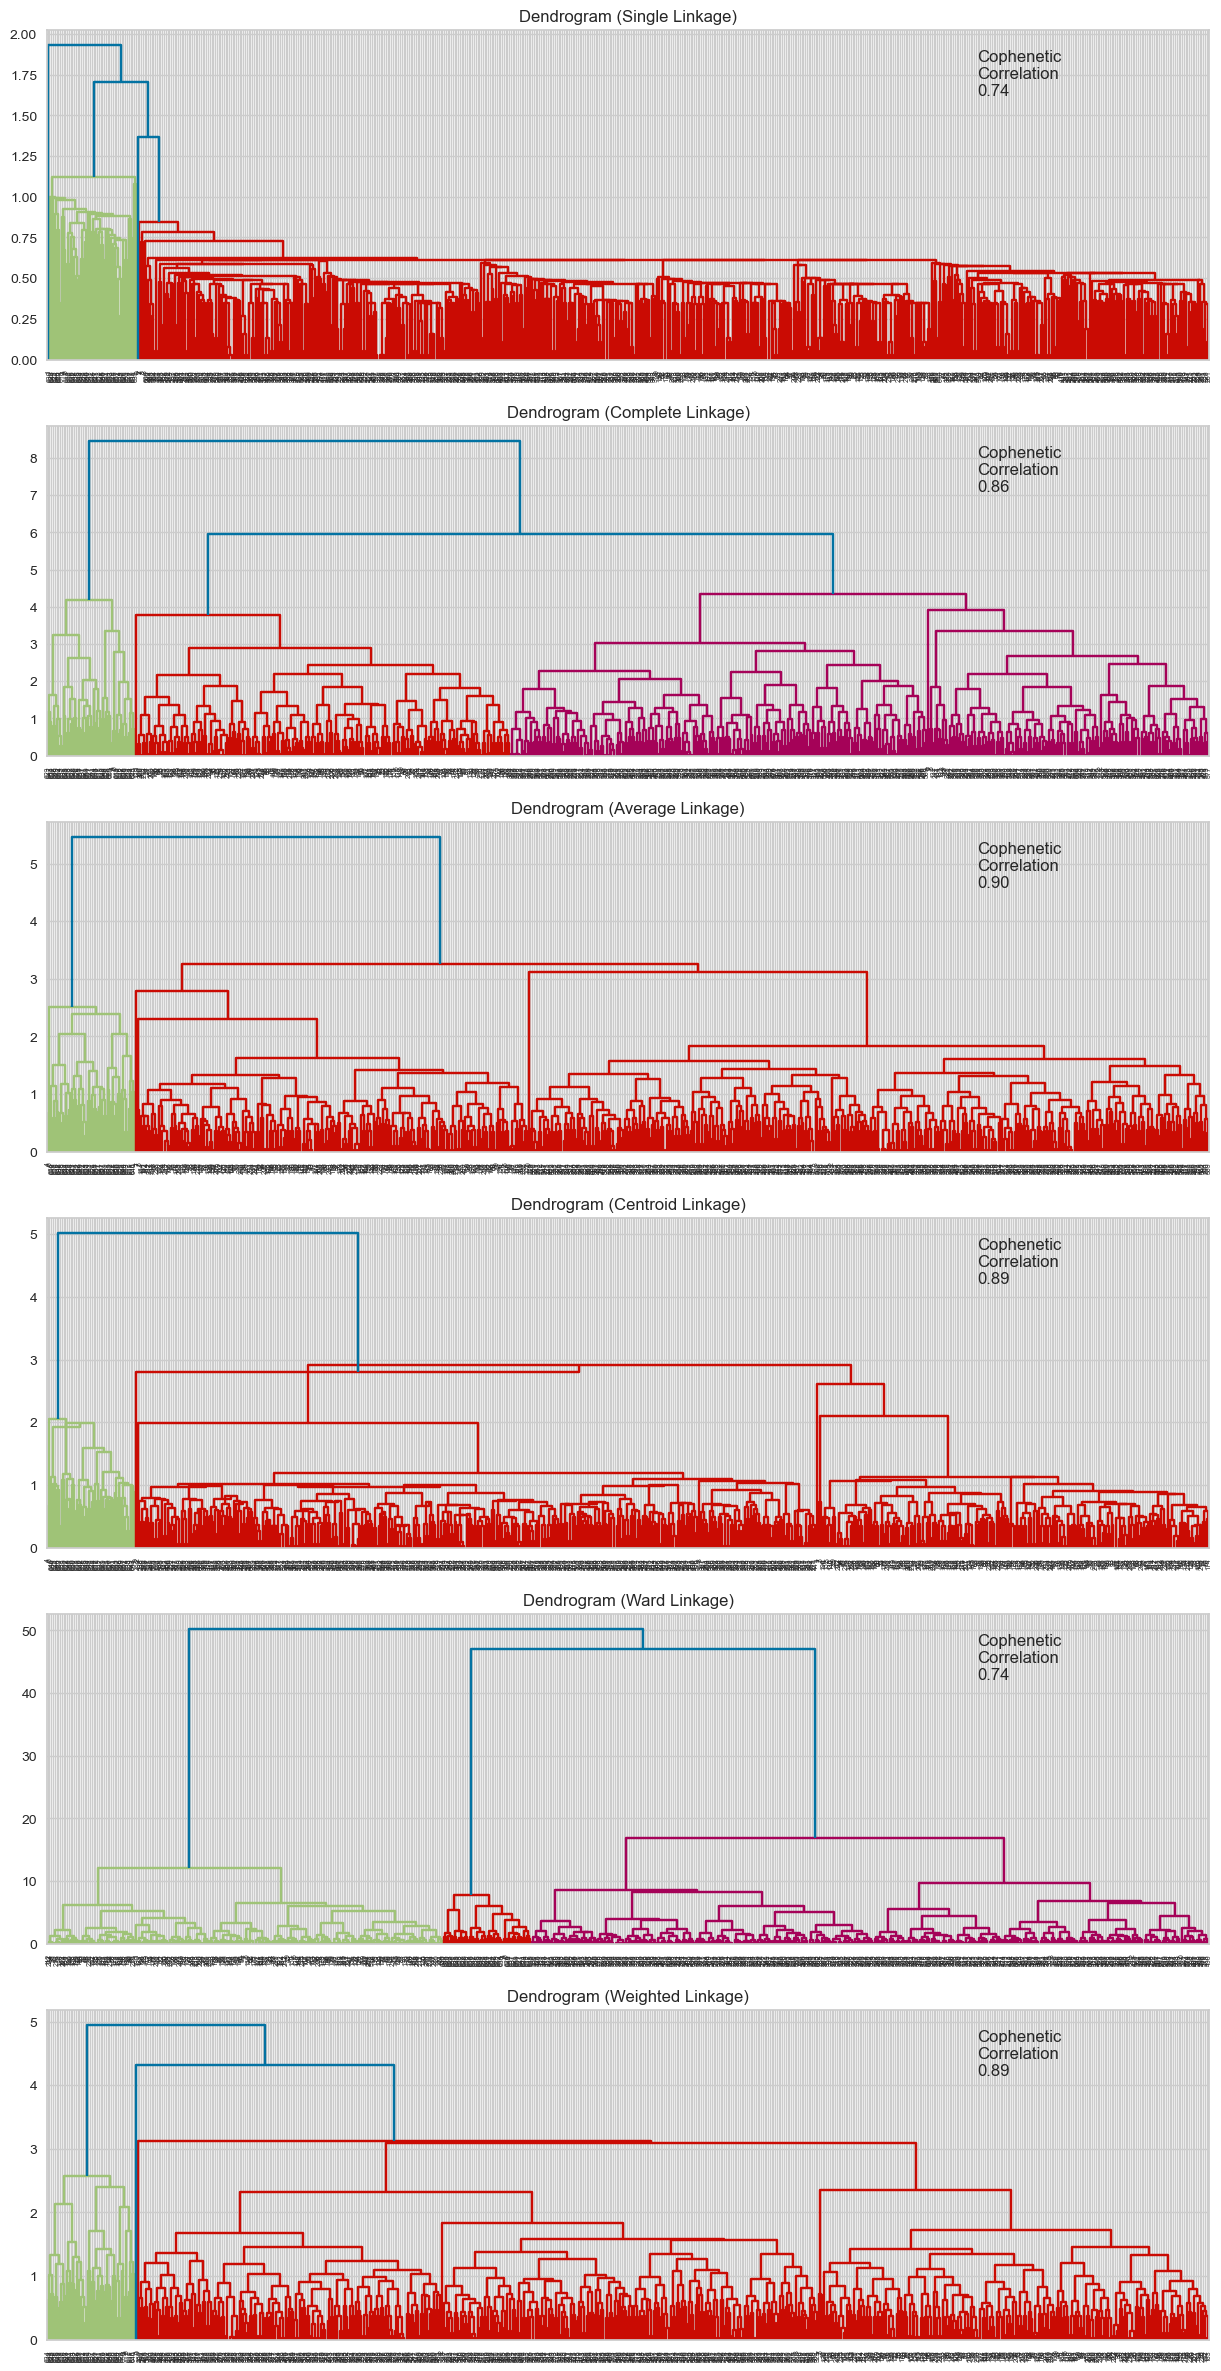

<IPython.core.display.Javascript object>

In [38]:
# list of linkage methods
linkage_methods = ["single", "complete", "average", "centroid", "ward", "weighted"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]
compare=[]
# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 30))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs[i])
    axs[i].set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs[i].annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
    compare.append([method,coph_corr])

In [39]:
# create and print a dataframe to compare cophenetic correlations for different linkage methods
df_cc = pd.DataFrame(compare, columns=compare_cols)
df_cc = df_cc.sort_values(by="Cophenetic Coefficient")
df_cc

,Linkage,Cophenetic Coefficient
0,single,0.739122
4,ward,0.741516
1,complete,0.859973
5,weighted,0.886175
3,centroid,0.893939
2,average,0.897708


<IPython.core.display.Javascript object>

#### Preview of Ward Linkage in larger format

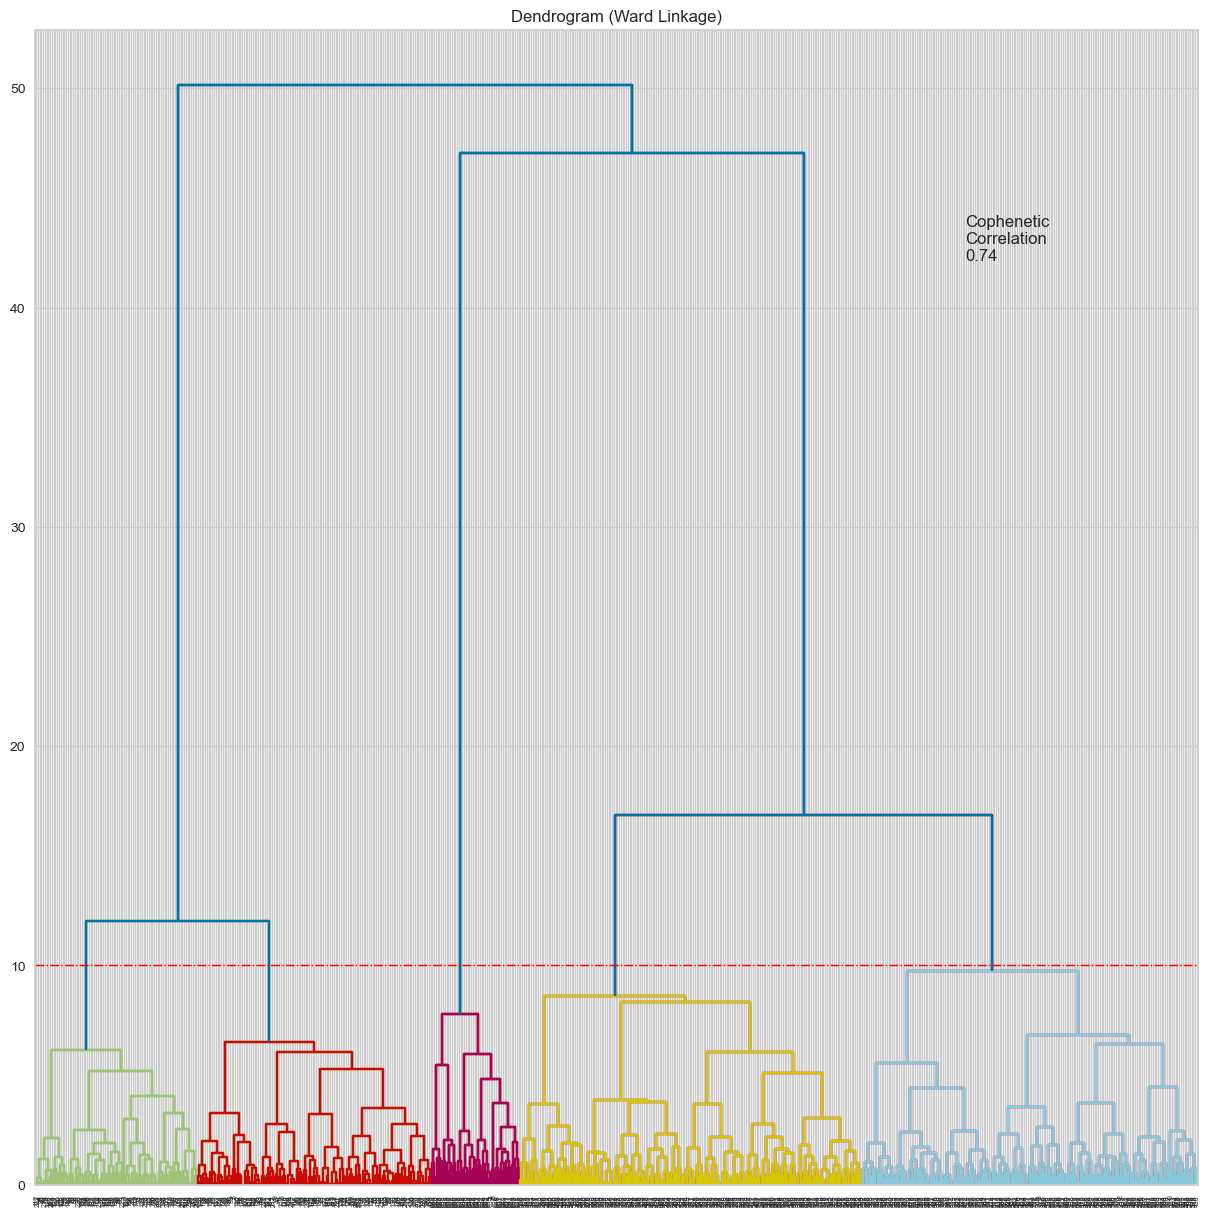

<IPython.core.display.Javascript object>

In [40]:
# list of linkage methods
linkage_methods = ["ward"]

# lists to save results of cophenetic correlation calculation
compare_cols = ["Linkage", "Cophenetic Coefficient"]

# to create a subplot image
fig, axs = plt.subplots(len(linkage_methods), 1, figsize=(15, 15))

# We will enumerate through the list of linkage methods above
# For each linkage method, we will plot the dendrogram and calculate the cophenetic correlation
for i, method in enumerate(linkage_methods):
    Z = linkage(hc_df, metric="euclidean", method=method)

    dendrogram(Z, ax=axs)
    axs.set_title(f"Dendrogram ({method.capitalize()} Linkage)")

    coph_corr, coph_dist = cophenet(Z, pdist(hc_df))
    axs.annotate(
        f"Cophenetic\nCorrelation\n{coph_corr:0.2f}",
        (0.80, 0.80),
        xycoords="axes fraction",
    )
dendrogram(Z, color_threshold=10)
plt.axhline(y=10, c="red", lw=1, linestyle="dashdot");

##### **Observations**
* The cophenetic correlation is highest for average and centroid linkage methods.
* However, after review of the dendrograms for each linkage method, the ward method provides larger variance within the dataset.
* 5 appears to be the appropriate number of clusters from the dendrogram for ward linkage. 

### Applying hierarchal clustering for Ward linkage and 5 clusters

In [41]:
HCmodel = AgglomerativeClustering(n_clusters=5, affinity="euclidean", linkage="ward")
HCmodel.fit(hc_df)

AgglomerativeClustering(affinity='euclidean', n_clusters=5)

<IPython.core.display.Javascript object>

In [42]:
#copy of original, unscaled data
hc_unscaled=df.copy()

# adding hierarchical cluster labels to the original and scaled dataframes
hc_df["HC_clusters"] = HCmodel.labels_
hc_unscaled["HC_clusters"] = HCmodel.labels_

hc_df.head(10)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,HC_clusters
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537,0
1,0.410293,-0.787585,-1.473731,2.520519,1.891859,4
2,0.410293,1.058973,-0.860451,0.134290,0.145528,0
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528,0
4,1.740187,0.597334,-1.473731,3.202298,-0.203739,2
5,-0.387644,-0.787585,-1.473731,-0.547490,1.542593,3
6,1.740187,0.135694,-1.473731,2.861408,-0.553005,2
7,-0.520633,-0.787585,-1.473731,-0.547490,-0.902271,3
8,-0.786612,-1.249225,-1.473731,-0.206600,-0.553005,3
9,-0.839808,-0.325946,-1.473731,-0.547490,1.193326,3


<IPython.core.display.Javascript object>

## Cluster Profiling and Comparison

### Cluster Profiling: K-Means Clustering

In [43]:
k_cluster_profile=df_unscaled.groupby('K_means_clusters').mean()

<IPython.core.display.Javascript object>

In [44]:
k_cluster_profile['count_in_each_segments'] = (
    df_unscaled.groupby('K_means_clusters')["Total_Credit_Cards"].count().values
)

<IPython.core.display.Javascript object>

In [45]:
k_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_clusters,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

### Cluster Profiling: Hierarchal Clustering

In [46]:
hc_cluster_profile=hc_unscaled.groupby('HC_clusters').mean()

<IPython.core.display.Javascript object>

In [47]:
hc_cluster_profile['count_in_each_segment'] = (
    hc_unscaled.groupby('HC_clusters')['Total_Credit_Cards'].count().values
)

<IPython.core.display.Javascript object>

In [48]:
hc_cluster_profile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_clusters,,,,,,
0,38298.429319,5.670157,2.523560,0.947644,2.099476,191
1,29474.226804,5.365979,4.448454,1.010309,1.891753,194
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,11834.586466,2.631579,0.977444,3.338346,5.556391,133
4,12608.695652,2.119565,0.880435,3.847826,8.739130,92


<IPython.core.display.Javascript object>

### K-Means vs. Hierarchal Clustering

#### Count

In [49]:
k_cluster_profile.style.highlight_max(color='mistyrose',axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segments
K_means_clusters,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


<IPython.core.display.Javascript object>

In [50]:
hc_cluster_profile.style.highlight_max(color="mistyrose", axis=0)

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,count_in_each_segment
HC_clusters,,,,,,
0,38298.429319,5.670157,2.523560,0.947644,2.099476,191
1,29474.226804,5.365979,4.448454,1.010309,1.891753,194
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50
3,11834.586466,2.631579,0.977444,3.338346,5.556391,133
4,12608.695652,2.119565,0.880435,3.847826,8.739130,92


<IPython.core.display.Javascript object>

#### Boxplot

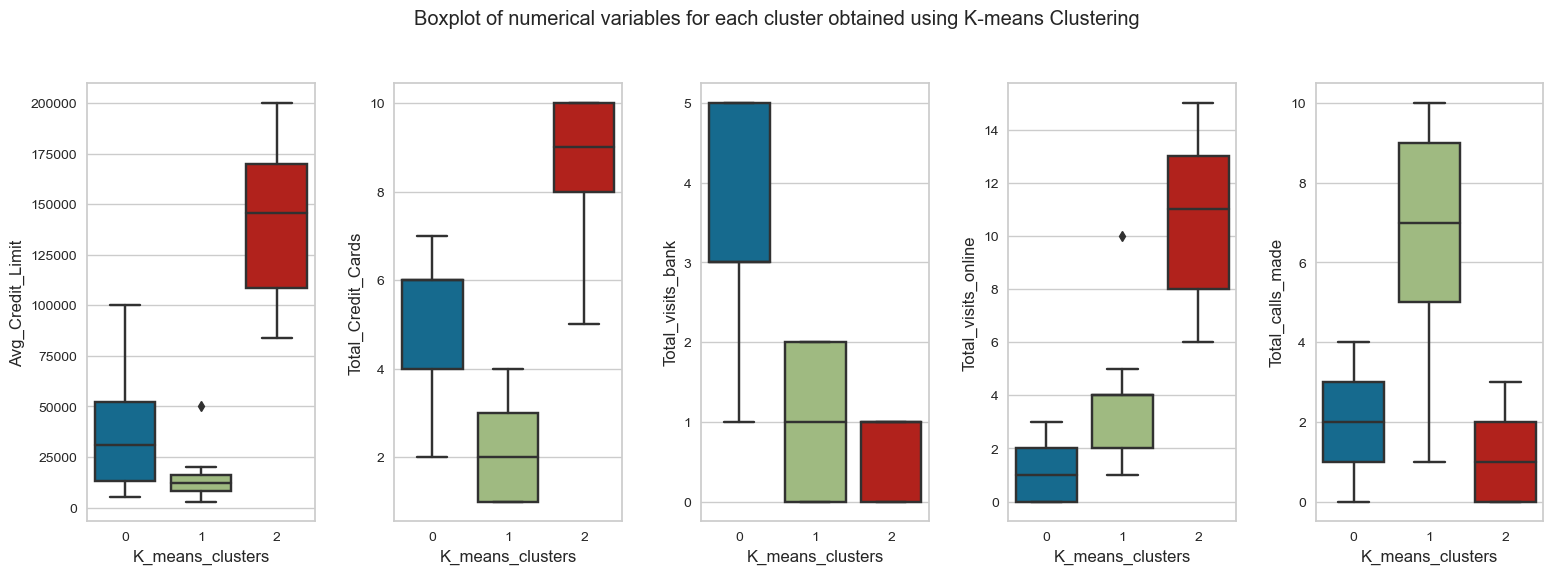

<IPython.core.display.Javascript object>

In [51]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle('Boxplot of numerical variables for each cluster obtained using K-means Clustering')
counter = 0
for ii in range(5):
    sns.boxplot(ax=axes[ii], y=df_unscaled[num_col[counter]], x=k_means_df['K_means_clusters'])
    counter = counter + 1

fig.tight_layout(pad=2.0)

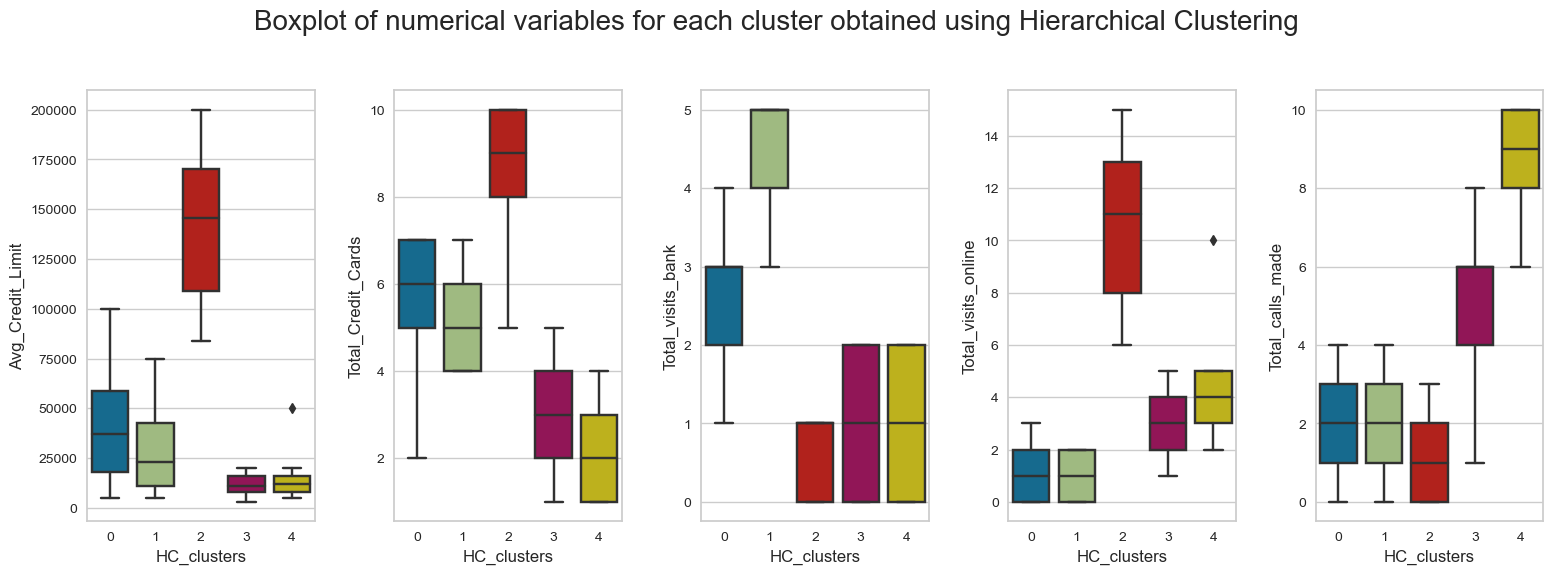

<IPython.core.display.Javascript object>

In [52]:
fig, axes = plt.subplots(1, 5, figsize=(16, 6))
fig.suptitle(
    "Boxplot of numerical variables for each cluster obtained using Hierarchical Clustering",
    fontsize=20,
)

counter = 0

for ii in range(5):
    sns.boxplot(ax=axes[ii], y=hc_unscaled[hc_unscaled.columns[counter]], x=hc_df["HC_clusters"])
    counter = counter + 1

fig.tight_layout(pad=2.0) 

#### Bar graph

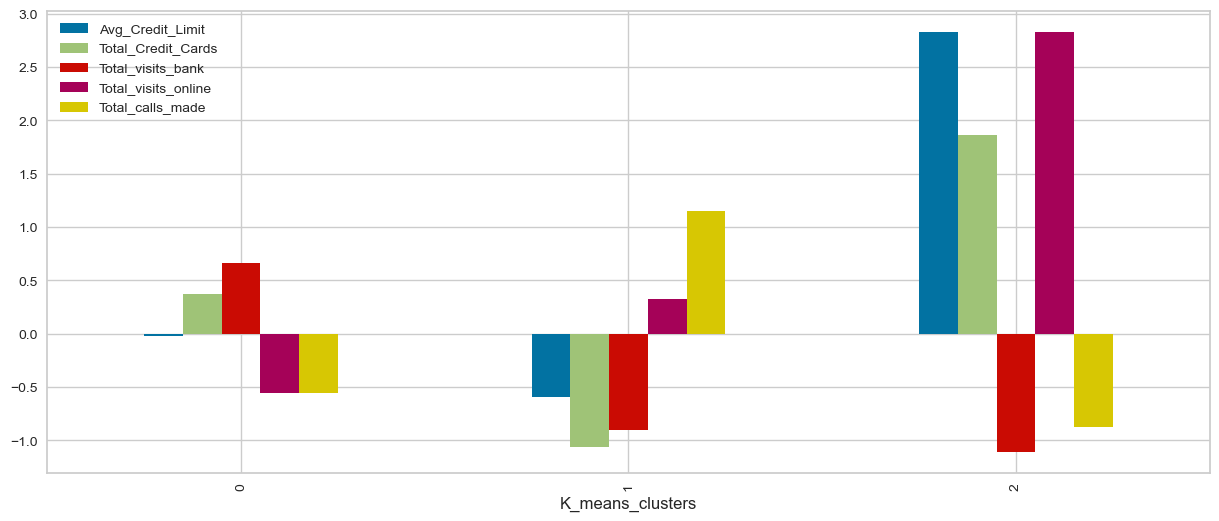

<IPython.core.display.Javascript object>

In [53]:
k_means_df.groupby('K_means_clusters').mean().plot.bar(figsize=(15, 6));

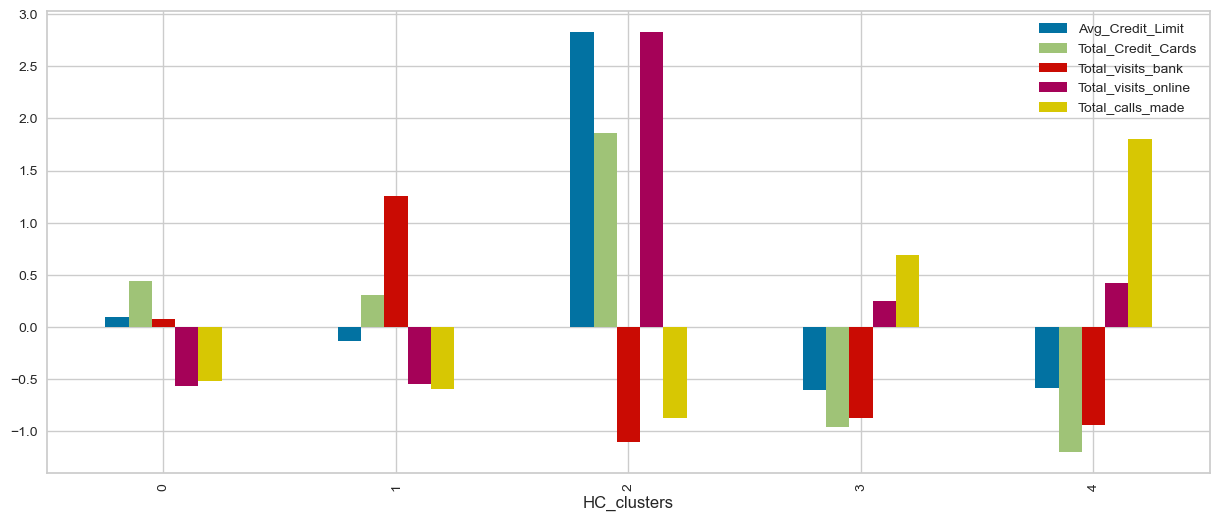

<IPython.core.display.Javascript object>

In [54]:
hc_df.groupby("HC_clusters").mean().plot.bar(figsize=(15, 6));

## Actionable Insights and Recommendations

#### **Insights: K-Means Cluster Profiling**

* **Cluster 0**
    - There are 386 customers in this cluster.
    - The average credit limit is about $35k.
    - They generally have between 4-6 credit cards.
    - They are likelier to visit a bank than they are to call or use the online services.

* **Cluster 1**
    - There are 224 customers in this cluster.
    - Amongst the other clusters, these customers have the lowest average credit limit and total number of credit cards.
    - They are likelier to call the bank more frequently.
    
* **Cluster 2**
     - There are 50 customers in this cluster.
     - They have the highest average credit limit. 
     - They generally have between 8-10 credit cards.
     - These customers are likelier to visit online than they are to call or visit the bank.


#### **Insights: Hierarchal Cluster Profiling**

* **Cluster 0**
    - There are 196 customers in this cluster.
    - The average credit limit is about $35k.
    - They have an average of 6 credit cards.
    - They are likelier to visit a bank than they are to call or use the online services.

* **Cluster 1**
    - There are 191 customers in this cluster.
    - They have an average credit limit of $25k.
    - They have an average of 5 credit cards.
    - These customers are the most frequent bank visitors.
    
* **Cluster 2**

    - There are 50 customers in this cluster.
    - Amongst the other clusters, these customers have the highest credit limit, averaging around $145k.
    - These customers also have the highest total number of cards averaging around 9 credit cards.
    - They are the most frequent online visitors.
    
* **Cluster 3**

    - There are 131 customers in this cluster.
    - These customers have the lowest credit limit amongst the other clusters.
    - These customers make an average of 6 calls to the bank.

* **Cluster 4**

    - There are 92 customers in this cluster.
    - They have the 2nd lowerst credit limit amongst the other clusters.
    - They are likelier to call the bank more frequently than any other clusters.



#### **Recommendations**


* Generally speaking, I would advise using the k-means cluster as the data for the marketing team to use to run personalized campaigns as clusters 3 and 4 from the hierarchal clustering method are very similar in output trends. 
* By using the k-means clusters, the marketing team is able to have a better segmentation across their customer base. 
* Based on the recommendations above, your customers can be segmented into 3 categories:
    1. *High credit card count + high visits*
        * Marketing opportunities for this segment is to get insight as to why they visit the bank frequently and potentially provide promotional marketing for these customers to purchase additional products from AllLife Bank through personal experience with the bankers at onsite locations. 
    2. *Low credit limit + high call volume*
        * One can assume that these borrowers may be experiencing poor customer service due to the frequency of their calls with minimal loyalty amongst the product itself as they have the lowest credit limit as well as total credit cards. There's large opportunity for these customers to improve customer service to build rapport and gain loyalty. 
    3. *High credit limit + high users + high online visits*
        * These customers are likely self sufficient and loyal custsomers. In order to maintain the loyalty of these customers, the marketing team can push a campaign to incentivize these clients to stay loyal by providing point bonuses, gifts, thank you letters, etc. 

___